In [181]:
import pandas as pd
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.interpolate import lagrange

In [2]:
class Node:
    def __init__(self, left=None, right=None, split=None, value=None):
        self.left = left
        self.right = right
        self.split = split
        self.value = value

In [166]:
class DecisionTree:
    
    '''
    Computes the entropy of given label values. axis of y?
    '''
    def entropy(self, y):
        if len(y) == 0:
            return 0
        p1 = np.mean(y)
        p0 = 1 - p1
        if p0 == 0 or p1 == 0:
            return 0
        return -p0 * np.log2(p0) - p1 * np.log2(p1)
    
    
    '''
    Computes the information gain caused by partitioning on a given attribute.
    '''
    def info_gain(self, y, split, X):
        j, c = split
        m, n = X.shape
        entropy_of_y = self.entropy(y)
        
        l_mask = X[:, int(j)] >= c
        r_mask = ~l_mask
        
        l_subset = y[l_mask]
        r_subset = y[r_mask]
        l_entropy = self.entropy(l_subset)
        r_entropy = self.entropy(r_subset)
        
        l_ratio = np.sum(l_mask) / m
        r_ratio = np.sum(r_mask) / m
        return entropy_of_y - (l_ratio * l_entropy + r_ratio * r_entropy)
    
    
    '''
    Computes the entropy of a split S (denominator of gain ratio).
    '''
    def split_info(self, y, split, X):
        j, c = split
        m, n = X.shape
        
        l_mask = X[:, int(j)] >= c
        r_mask = ~l_mask
        
        l_ratio = np.sum(l_mask) / m
        r_ratio = np.sum(r_mask) / m
        
        if(l_ratio == 0 or r_ratio == 0):
            return 0
        return - l_ratio * np.log2(l_ratio) - r_ratio * np.log2(r_ratio)
    
    
    '''
    Computes the gain ratio.
    '''
    def gain_ratio(self, info_gain, split_info):
        return info_gain/split_info
    
    
    '''
    Determines candidate numeric splits (use a threshold c in feature dimension j in the form of xj ≥ c
    '''
    def candidate_splits(self, X):
        splits = [] # initialize set of candidate splits for feature matrix X
        m, n = X.shape
        for j in range(n):
            sorted_X = X[X[:, j].argsort()] # Sort array data based on the values in the jth column
            unique_c_values = np.unique(sorted_X[:, j])
            for c in unique_c_values:
                splits.append((j, c))
        return np.array(splits)
    
    '''
    Computes the best split
    '''
    def find_best_split(self, X, y, splits):
        best_split = None
        best_gain_ratio = -np.inf
        m, n = X.shape
        if np.unique(y).shape[0] == 1:
            return best_split
        for split in splits:
            j,c = split
            
            l_mask = X[:, int(j)] >= c
            r_mask = ~l_mask
            
            if np.any(l_mask) and np.any(r_mask):
                info_gain  = self.info_gain(y, split, X)
                split_info = self.split_info(y, split, X)
                
                gain_ratio = self.gain_ratio(info_gain, split_info)
                
                if gain_ratio > best_gain_ratio:
                    best_gain_ratio = gain_ratio
                    best_split = split
        
        return best_split
    
    '''
    Get class label for leaf node N.
    '''
    def get_class_label(self, y):
        if sum(y == 0) > sum(y==1):
            return 0
        else:
            return 1
        
    
    '''
    Build a decision tree.
    '''
    def make_subtree(self, data):
        X, y = data[:, :-1], data[:, -1]
        
        splits = self.candidate_splits(X)
        best_split = self.find_best_split(X, y, splits)
        
        if best_split is None:
            leaf_value = self.get_class_label(y)
            return Node(split=best_split, value=leaf_value)
        
        j,c = best_split
        l_mask = X[:, int(j)] >= c
        r_mask = ~l_mask
        left_node  = self.make_subtree(data[l_mask])
        right_node = self.make_subtree(data[r_mask])
        return Node(left=left_node, right=right_node, split=best_split)
    
    
    '''
    Fit the decision tree.
    '''
    def fit(self, data):
        self.root = self.make_subtree(data)
    
    
    '''
    Predicts class labels for feature matrix X
    '''
    def predict(self, X):
        return np.array([self.predict_tree(x, self.root) for x in X])
    
    
    '''
    Predict class labels for instance x
    '''
    def predict_tree(self, x, node):
        # if the node has value, it is a leaf node
        if node.value != None:
            return node.value
        
        j,c = node.split
        if x[int(j)] >= c:
            return self.predict_tree(x, node.left)
        else:
            return self.predict_tree(x, node.right)
        
        
    '''
    Function for question 3
    '''
    def calculate_split_information(self, data):
        X, y = data[:, :-1], data[:, -1]
        
        splits = self.candidate_splits(X)
        print("Candidate splits (j,c):")
        for split in splits:
            info_gain  = self.info_gain(y, split, X)
            split_info = self.split_info(y, split, X)
            if (split_info > 0):
                gain_ratio = self.gain_ratio(info_gain, split_info)
                print("(" + str(int(split[0])) + ", " + str(split[1]) + ") -> Gain Ratio: " + str(gain_ratio))
            else:
                print("(" + str(int(split[0])) + ", " + str(split[1]) + ") -> Information Gain: " + str(info_gain))
                
    '''
    Function for printing tree
    '''
    def print_tree(self, node):
        if node is None:
            return
        queue = deque()
        queue.append(node)
        
        while(len(queue) > 0):
            node = queue.popleft()
            if node.value is None:
                print(node.split, end = " ")
            else:
                print("leaf: " + str(node.value), end = " ")
            
            if node.left is not None:
                queue.append(node.left)
                
            if node.right is not None:
                queue.append(node.right)
    
        
    '''
    Create a Graphviz DOT format representation of the decision tree.
    '''
    def to_dot(self):
        dot = graphviz.Digraph(format='png')
        self._add_nodes(dot, self.root)
        return dot
    
    def _add_nodes(self, dot, node):
        if node.value is not None:
            dot.node(str(id(node)), label=f"y = {node.value}")
        else:
            dot.node(str(id(node)), label=f"x{int(node.split[0])} >= {node.split[1]}", shape='box')
            dot.edge(str(id(node)), str(id(node.left)), label='T')
            dot.edge(str(id(node)), str(id(node.right)), label='F')
            self._add_nodes(dot, node.left)
            self._add_nodes(dot, node.right)
            
    
    '''
    Plot decision boundary
    '''
    def plot_decision_boundary(self, node, data, titlename, filename):
        X, y = data[:, :-1], data[:, -1]
        
        #cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])  # Background color
        cmap_background = ListedColormap(['#FFAAAA', 'cornflowerblue'])  # Background color
        cmap_points = ListedColormap(['#FF0000', '#0000FF'])  # Point color
        
        # Create a mesh grid of points
        h = 0.01 # Step size in the mesh
        x0_min, x0_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        #plt.figure(figsize=(8,6))
        plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_points, edgecolor='k', s=20)
        plt.xlabel('$x_0$')
        plt.ylabel('$x_1$')
        plt.title(titlename)
        plt.savefig(filename)
        plt.show()
        
    '''
    Find test set error
    '''
    def test_set_error(self, data):
        X_test, y_test = data[:, :-1], data[:, -1]
        predictions = self.predict(X_test)
        return np.mean(predictions != y_test)
    
    '''
    Find number of nodes in the tree
    '''
    def num_of_nodes(self, node):
        if node is None:
            return 0
        l_count = self.num_of_nodes(node.left)
        r_count = self.num_of_nodes(node.right)
        return l_count + r_count + 1
    
    

In [5]:
# Question 3
data3 = np.loadtxt("Druns.txt")
tree3 = DecisionTree()
tree3.calculate_split_information(data3)

Candidate splits (j,c):
(0, 0.0) -> Information Gain: 0.0
(0, 0.1) -> Gain Ratio: 0.10051807676021828
(1, -2.0) -> Information Gain: 0.0
(1, -1.0) -> Gain Ratio: 0.10051807676021828
(1, 0.0) -> Gain Ratio: 0.055953759631263526
(1, 1.0) -> Gain Ratio: 0.00578004220515232
(1, 2.0) -> Gain Ratio: 0.0011443495172767494
(1, 3.0) -> Gain Ratio: 0.016411136842102134
(1, 4.0) -> Gain Ratio: 0.049749064181778546
(1, 5.0) -> Gain Ratio: 0.11124029586339801
(1, 6.0) -> Gain Ratio: 0.23609960614360798
(1, 7.0) -> Gain Ratio: 0.055953759631263526
(1, 8.0) -> Gain Ratio: 0.4301569161309807


In [65]:
# Question 4
data4 = np.loadtxt("D3leaves.txt")
tree4 = DecisionTree()
root = tree4.make_subtree(data4)
tree4.print_tree(root)

[ 0. 10.] leaf: 1 [1. 3.] leaf: 1 leaf: 0 

In [89]:
# Question 5a
data5a = np.loadtxt("D1.txt")
tree5a = DecisionTree()
root5a = tree5a.make_subtree(data5a)
tree5a.print_tree(root5a)

[1.       0.201829] leaf: 1 leaf: 0 

In [90]:
# Question 5b
data5b = np.loadtxt("D2.txt")
tree5b = DecisionTree()
root5b = tree5b.make_subtree(data5b)
tree5b.print_tree(root5b)

[0.       0.533076] [1.       0.228007] [1.      0.88635] [1.       0.424906] [0.       0.887224] [0.       0.041245] [1.       0.691474] leaf: 1 [0.       0.708127] [1.       0.037708] [0.       0.850316] [0.       0.104043] leaf: 0 [0.       0.254049] [1.       0.534979] leaf: 1 [1.      0.32625] [1.       0.082895] leaf: 0 [1.       0.169053] leaf: 0 leaf: 1 [0.      0.07642] leaf: 1 [0.       0.191915] [0.       0.426073] leaf: 0 [0.       0.595471] leaf: 0 leaf: 1 [0.       0.960783] leaf: 1 leaf: 0 leaf: 0 leaf: 1 [1.       0.792752] [1.       0.864128] leaf: 1 [0.       0.409972] [0.       0.646007] leaf: 0 leaf: 1 leaf: 0 leaf: 1 leaf: 0 [0.       0.144781] leaf: 0 [0.       0.417579] [0.       0.393227] leaf: 1 [1.       0.403494] leaf: 1 leaf: 0 leaf: 0 leaf: 1 [0.      0.39583] leaf: 0 leaf: 1 leaf: 0 leaf: 0 leaf: 1 

In [32]:
# Visualize the decision tree using Graphviz
dot5a = tree5a.to_dot()
dot5a.render('decision_tree_d1', view=True)

'decision_tree_d1.png'

In [45]:
# Visualize the decision tree using Graphviz
dot5b = tree5b.to_dot()
dot5b.render('decision_tree_d2', view=True)

'decision_tree_d2.png'

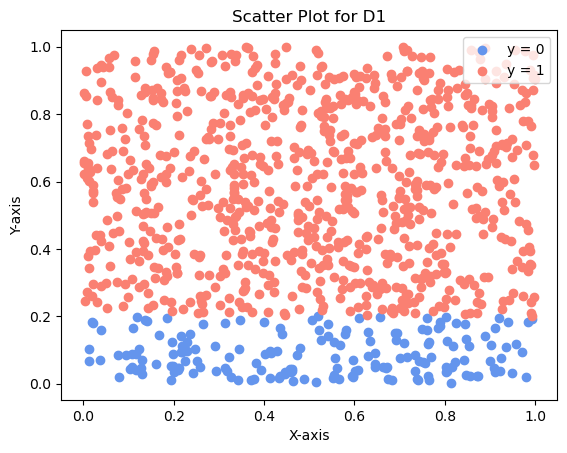

In [82]:
# Question 6a: Produce a scatter plot of the data set D1 and D2.

# Separate the data into two classes (0 and 1)
class_0 = [(x, y) for x, y, label in data5a if label == 0]
class_1 = [(x, y) for x, y, label in data5a if label == 1]

plt.scatter(*zip(*class_0), label='y = 0', color='cornflowerblue', marker='o')
plt.scatter(*zip(*class_1), label='y = 1', color='salmon', marker='o')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot for D1')
plt.legend(loc="upper right")
plt.savefig("scatter_plot_d1.png")
plt.show()

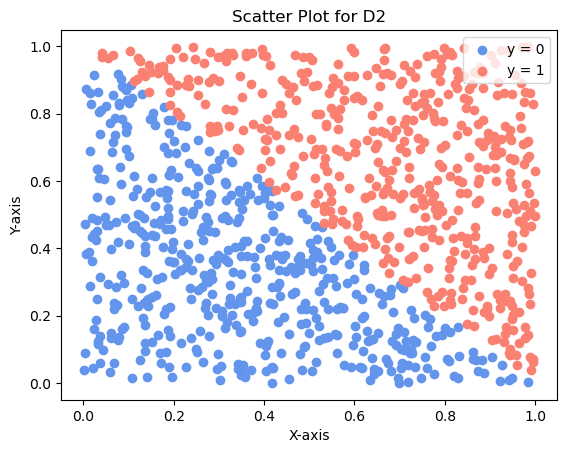

In [63]:
# Question 6a: Produce a scatter plot of the data set D1 and D2.

# Separate the data into two classes (0 and 1)
class_0 = [(x, y) for x, y, label in data5b if label == 0]
class_1 = [(x, y) for x, y, label in data5b if label == 1]

plt.scatter(*zip(*class_0), label='y = 0', color='cornflowerblue', marker='o')
plt.scatter(*zip(*class_1), label='y = 1', color='salmon', marker='o')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot for D2')
plt.legend(loc="upper right")
plt.savefig("scatter_plot_d2.png")
plt.show()

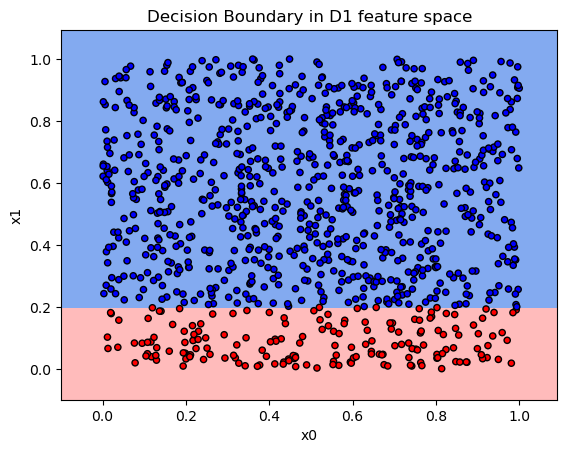

In [86]:
# Question 6b: Visualize your decision tree’s decision boundary
tree5a.fit(data5a)
X_5a, y_5a = data5a[:, :-1], data5a[:, -1]
tree5a.plot_decision_boundary(root5a, data5a, 'Decision Boundary in D1 feature space', 'boundary_d1.png')

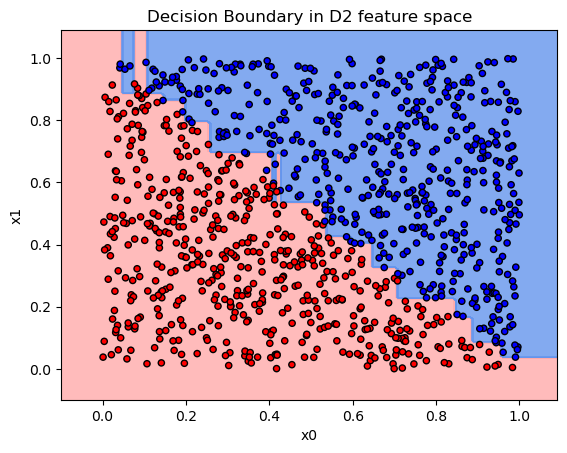

In [87]:
# Question 6b: Visualize your decision tree’s decision boundary
tree5b.fit(data5b)
X_5b, y_5b = data5b[:, :-1], data5b[:, -1]
tree5b.plot_decision_boundary(root5b, data5b, 'Decision Boundary in D2 feature space', 'boundary_d2.png')

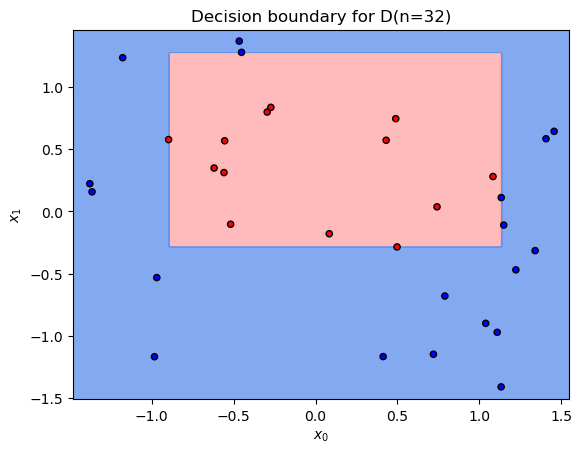

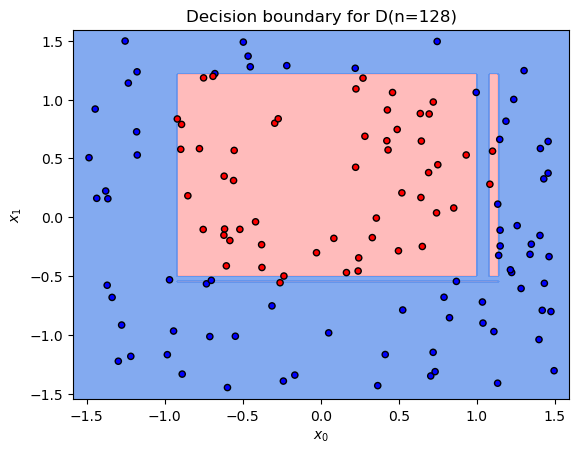

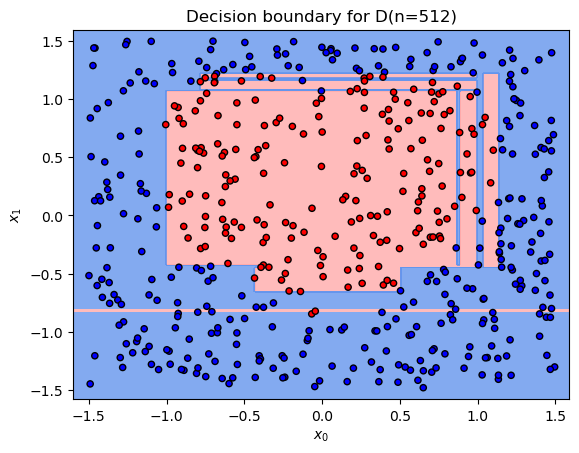

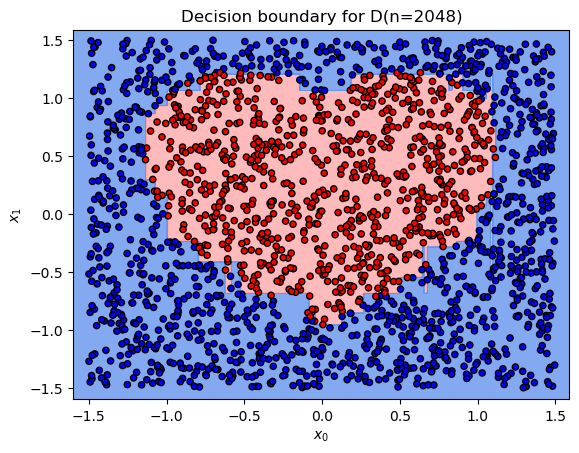

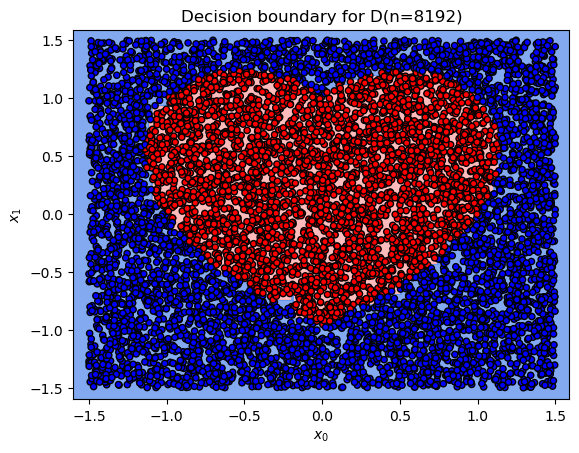

In [170]:
#Question 7
data_big = np.loadtxt('Dbig.txt')

training_set_size = 8192
shuffled_indices = np.random.permutation(data_big.shape[0]) # Generate a random permutation of indices

train_set = data_big[shuffled_indices[:training_set_size]]
test_set  = data_big[shuffled_indices[training_set_size:]]

training_set_sizes = [32, 128, 512, 2048, 8192]
num_of_nodes = []
errors = []

tree_big = DecisionTree()

for size in training_set_sizes:
    nested_train_set = data_big[shuffled_indices[:size]]
    root_big = tree_big.make_subtree(nested_train_set)
    tree_big.fit(nested_train_set)
    tree_big.plot_decision_boundary(root_big, nested_train_set,'Decision boundary for D(n='+ str(size)+')','boundary_'+ str(size) +'.png')
    num_of_nodes.append(tree_big.num_of_nodes(root_big))
    errors.append(tree_big.test_set_error(test_set))

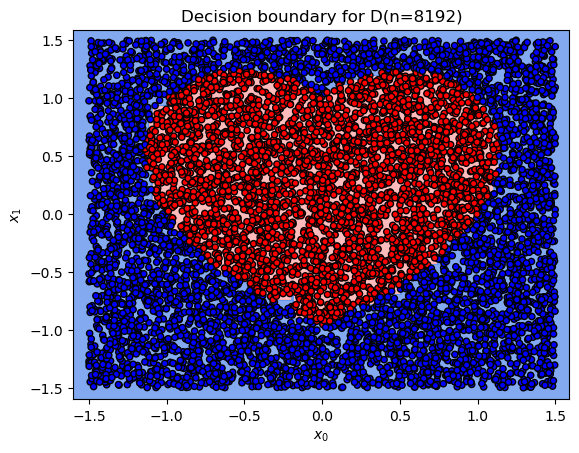

In [171]:
tree_big = DecisionTree()
nested_train_set = data_big[shuffled_indices[:8192]]
root_big = tree_big.fit(nested_train_set)
tree_big.plot_decision_boundary(root_big, nested_train_set,'Decision boundary for D(n='+ str(size)+')','boundary2_'+ str(size) +'.png')

In [134]:
num_of_nodes

[11, 19, 57, 129, 287]

In [135]:
errors

[0.2972, 0.0763, 0.0663, 0.0266, 0.0034]

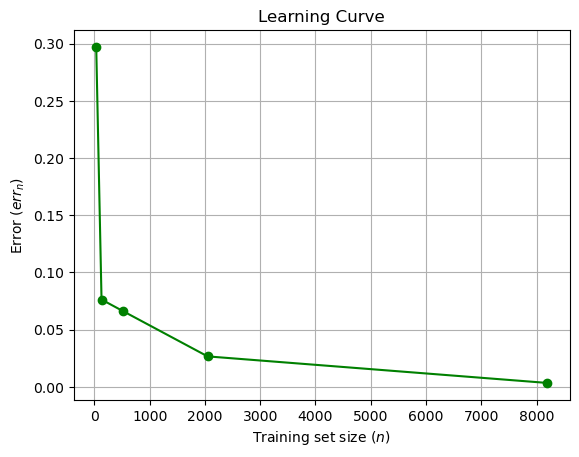

In [150]:
plt.plot(training_set_sizes, errors, marker='o', linestyle='-', color='g')
plt.xlabel('Training set size $(n)$')
plt.ylabel('Error $(err_{n})$')
plt.title('Learning Curve')
plt.grid(True)
#plt.savefig('learning_curve_Dbig.png')
plt.show()

In [177]:
# Question 3
training_set_sizes = [32, 128, 512, 2048, 8192]
node_counts = []
errors = []

for size in training_set_sizes:
    X_train = data_big[shuffled_indices[:size]][:, :-1]
    y_train = data_big[shuffled_indices[:size]][:, -1]
    
    tree_model = DecisionTreeClassifier()
    tree_model.fit(X_train, y_train)
    
    num_nodes = tree_model.tree_.node_count
    node_counts.append(num_nodes)
    
    X_test, y_test = test_set[:, :-1], test_set[:, -1]
    y_pred = tree_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    err_n = 1.0 - accuracy
    errors.append(err_n)

In [178]:
print(node_counts)
print(errors)

[9, 17, 41, 115, 235]
[0.11504424778761058, 0.07688053097345138, 0.07024336283185839, 0.023230088495575174, 0.014380530973451378]


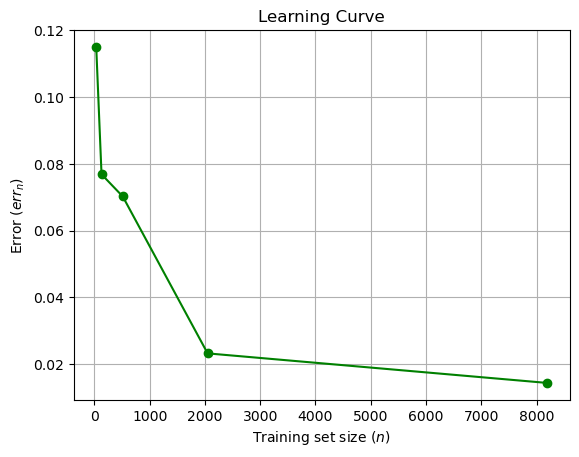

In [180]:
plt.plot(training_set_sizes, errors, marker='o', linestyle='-', color='g')
plt.xlabel('Training set size $(n)$')
plt.ylabel('Error $(err_{n})$')
plt.title('Learning Curve')
plt.grid(True)
plt.savefig('learning_curve_sklearn.png')
plt.show()

In [239]:
# Question 4
a, b = 0, 2 * np.pi
n = 100

np.random.seed
X_train = np.random.uniform(a, b, n)
y_train = np.sin(X_train)

poly = lagrange(X_train, y_train)

X_test = np.random.uniform(a, b, n)
y_test = np.sin(X_test)

def log_mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.log(mse)

train_set_error = log_mean_squared_error(y_train, poly(X_train))
test_set_error  = log_mean_squared_error(y_test, poly(X_test))

print(train_set_error, test_set_error)

384.05446820280804 383.6802041842777


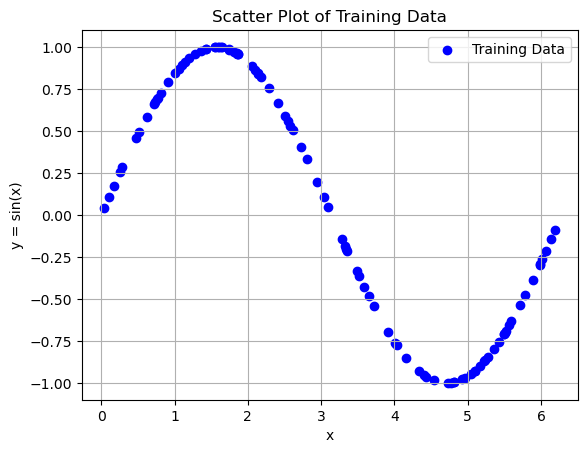

In [237]:
plt.scatter(X_train, y_train, label="Training Data", c="blue", marker="o")
#plt.plot(X_train, y_train_pred, label="Interpolated Function", c="green")
plt.xlabel("x")
plt.ylabel("y = sin(x)")
plt.title("Scatter Plot of Training Data")
plt.legend()
plt.grid(True)
plt.show()

In [244]:
epsilons = np.linspace(0,10,10)

train_errors = []
test_errors = []

for epsilon in epsilons:
    X_train_noisy = X_train + np.random.normal(0, epsilon, n)
    y_train_noisy = np.sin(X_train_noisy)
    
    poly_new = lagrange(X_train_noisy, y_train_noisy)
    
    train_set_error = log_mean_squared_error(y_train, poly_new(X_train))
    test_set_error  = log_mean_squared_error(y_test, poly_new(X_test))
    print(epsilon, train_set_error, test_set_error)
    
    train_errors.append(train_set_error)
    test_errors.append(test_set_error)

0.0 384.05446820280804 383.6802041842777
1.1111111111111112 341.021531767946 340.6611652982925
2.2222222222222223 293.84341314717875 293.4808938614738
3.3333333333333335 219.63061931753006 219.26758784316777
4.444444444444445 142.68674774199332 142.34366778701678
5.555555555555555 150.68136498479404 150.32722179425397
6.666666666666667 99.67888437235298 99.28921089777876
7.777777777777779 95.03624014682646 94.65861943884214
8.88888888888889 97.42127760677423 97.03358204294979
10.0 53.92361136531512 53.53522852890724


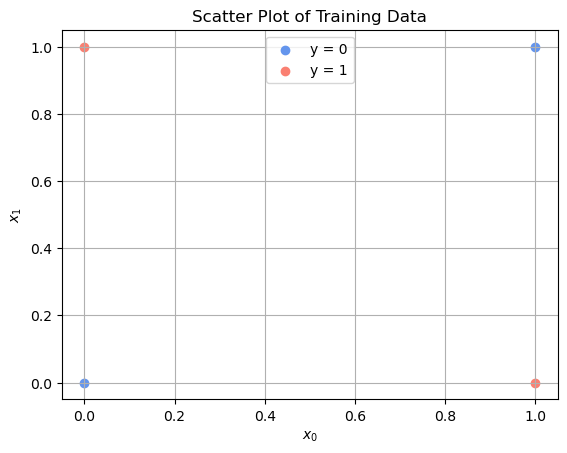

In [260]:
# Question 2
data = np.array([[0, 0, 0], [0, 1, 1], [1, 1, 0], [1, 0, 1]])
X, y = data[:, :-1], data[:,-1]

# Separate the data into two classes (0 and 1)
class_0 = [(x, y) for x, y, label in data if label == 0]
class_1 = [(x, y) for x, y, label in data if label == 1]

plt.scatter(*zip(*class_0), label='y = 0', color='cornflowerblue', marker='o')
plt.scatter(*zip(*class_1), label='y = 1', color='salmon', marker='o')

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.title("Scatter Plot of Training Data")
plt.legend(loc="upper center")
plt.grid(True)
plt.savefig("scatter_plot_q2.png")
plt.show()

In [261]:
dt = DecisionTree()
root = dt.make_subtree(data)
dt.print_tree(root)

[0 1] [1 1] [1 1] leaf: 0 leaf: 1 leaf: 1 leaf: 0 

In [262]:
dt.calculate_split_information(data)

Candidate splits (j,c):
(0, 0) -> Information Gain: 0.0
(0, 1) -> Gain Ratio: 0.0
(1, 0) -> Information Gain: 0.0
(1, 1) -> Gain Ratio: 0.0
